**Содержание**<a id='toc0_'></a>    
- [Определение стоимости автомобилей](#toc1_)    
  - [Подготовка данных](#toc1_1_)    
    - [Анализ и предобработка данных](#toc1_1_1_)    
      - [Price](#toc1_1_1_1_)    
      - [VehicleType - категориальный признак](#toc1_1_1_2_)    
      - [RegistrationYear](#toc1_1_1_3_)    
      - [Gearbox  - категориальный признак](#toc1_1_1_4_)    
      - [Power](#toc1_1_1_5_)    
      - [Model - категориальный признак](#toc1_1_1_6_)    
      - [Kilometer](#toc1_1_1_7_)    
      - [RegistrationMonth](#toc1_1_1_8_)    
      - [FuelType - Категориальный признак](#toc1_1_1_9_)    
      - [Brand - Категориальный признак](#toc1_1_1_10_)    
      - [Repaired - Категориальный признак.](#toc1_1_1_11_)    
      - [PostalCode](#toc1_1_1_12_)    
    - [Разбивка на выборки](#toc1_1_2_)    
    - [Кодировка](#toc1_1_3_)    
    - [Масштабирование](#toc1_1_4_)    
    - [Объеденяем выборки](#toc1_1_5_)    
  - [Обучение моделей](#toc1_2_)    
    - [Случайный лес](#toc1_2_1_)    
    - [Линейная регрессия](#toc1_2_2_)    
    - [LightGBM](#toc1_2_3_)    
    - [CatBoost](#toc1_2_4_)    
  - [Анализ моделей](#toc1_3_)    
    - [Проверка лучшей на тестовых данных](#toc1_3_1_)    
  - [Вывод:](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Определение стоимости автомобилей](#toc0_)

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## <a id='toc1_1_'></a>[Подготовка данных](#toc0_)

In [1]:
#загрузка библиотек
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import OrdinalEncoder 
import lightgbm as lgb

In [2]:
display(HTML("<style>.container { width:75% !important; }</style>")) # больше не делаю, экран не такой большой как хотелось бы

In [3]:
data = pd.read_csv('/datasets/autos.csv')
display(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В датасете 16 столбцов и 354369 строк.

Признаки:

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    Repaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя
    
Целевой признак:

    Price — цена (евро)
    
По первым строкам датасета уже видно что есть пропущенные значения в данных. Ниже посмотрим на количество пропусков, а также поработаем над их устранением. 


In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Заметки:
    
    Столбцы DateCrawled, DateCreated, LastSeen  - столбцы с датами, их надо преобразовать к типу datetime
    В столбце RegistrationYear - есть значения 1000 и 9999 - явно выбросы, необходимо изучить столбец более подробно. 
    В столбце Power также имеются выбросы, максимальное значение 20.000 - оно не реально, машина - монстр Devel Sixteen (5000 л. с.), является самой мощной машиной в мире и есть всего в 3х экземплярах. Да и в минимальном значении есть нули, что можно тоже посчитать некорректными данными. Нужно более подробно разобрать данный столбец.  
    В столбце Price есть нулевые значения. 
    В столбце NumberOfPictures - одни нули, данный столбец бесполезен нам для дальнейшего исследования, его можно убрать из датасета. 

    

In [5]:
# удаляем столбцец
data = data.drop('NumberOfPictures', axis=1)


In [6]:
# Преобразовываем временные столбцы
data[['DateCrawled', 'DateCreated', 'LastSeen']] = data[['DateCrawled', 'DateCreated', 'LastSeen']].apply(pd.to_datetime)

In [7]:
#check
display(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  PostalCode         354369 non-null  int64   

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21


In [8]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
PostalCode               0
LastSeen                 0
dtype: int64

In [9]:
round(data.isna().mean(), 2)

DateCrawled          0.00
Price                0.00
VehicleType          0.11
RegistrationYear     0.00
Gearbox              0.06
Power                0.00
Model                0.06
Kilometer            0.00
RegistrationMonth    0.00
FuelType             0.09
Brand                0.00
Repaired             0.20
DateCreated          0.00
PostalCode           0.00
LastSeen             0.00
dtype: float64

Как я уже и говорил выше, в датасете есть пропущенные значения, максимальная доля пропущенных значений 0.2. В целевом признаке нет пропусков.  

In [10]:
if data.duplicated().sum() == 0:
    print('Дубликатов нет')
else:
    print(data.duplicated().sum())

4


In [11]:
data = data.drop_duplicates()
if data.duplicated().sum() == 0:
    print('Дубликатов нет')
else:
    print(data.duplicated().sum())

Дубликатов нет


Нашли и избавились от дубликатов, их было всего 4 шутки. 

### <a id='toc1_1_1_'></a>[Анализ и предобработка данных](#toc0_)

Изучим преобразованные столбцы с датами.

In [12]:
date =['DateCrawled', 'DateCreated', 'LastSeen']

In [13]:
for i in date:
    print(i)
    print(data[i].describe(), '\n')

DateCrawled
count                  354365
unique                 271174
top       2016-03-24 14:49:47
freq                        7
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: DateCrawled, dtype: object 

DateCreated
count                  354365
unique                    109
top       2016-04-03 00:00:00
freq                    13718
first     2014-03-10 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object 

LastSeen
count                  354365
unique                 179150
top       2016-04-06 13:45:54
freq                       17
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: LastSeen, dtype: object 



/tmp/ipykernel_447/4106584414.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(data[i].describe(), '\n')
/tmp/ipykernel_447/4106584414.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(data[i].describe(), '\n')
/tmp/ipykernel_447/4106584414.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(data[i].describe(), '\n')


DateCrawled - дата скачивания анкеты из базы. Тут мы можем заметить, что выгрузка была с 5 марта 16го года по 7го апреля 16го года. 

DateCreated — дата создания анкеты. Тут данные за период с 10 марта 14го года по 7 апреля 16 года.

LastSeen — дата последней активности пользователя. Активность пользователь была  в период с 5 марта 16го года по 7 апреля 16 года.

В датасете есть стобцы с годом и месяцем регистрации авто, следовательно не должно быть записей с авто после апреля 16го года.
Столбцы с датами больше нам не понадобятся, мы можем удалить их с датасета.

In [14]:
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354365 non-null  int64 
 1   VehicleType        316875 non-null  object
 2   RegistrationYear   354365 non-null  int64 
 3   Gearbox            334532 non-null  object
 4   Power              354365 non-null  int64 
 5   Model              334660 non-null  object
 6   Kilometer          354365 non-null  int64 
 7   RegistrationMonth  354365 non-null  int64 
 8   FuelType           321470 non-null  object
 9   Brand              354365 non-null  object
 10  Repaired           283211 non-null  object
 11  PostalCode         354365 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 35.1+ MB


In [15]:
data['RegistrationMonth'].head()

0    0
1    5
2    8
3    6
4    7
Name: RegistrationMonth, dtype: int64

Сделаем новый датасет с данными до апреля (включительно) 16го года.

In [16]:
new_data= data[(data['RegistrationYear'] < 2016) | ((data['RegistrationYear'] == 2016) & (data['RegistrationMonth'] <= 4))]
display(new_data.head(10))
display(new_data.info())
display(new_data.shape)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,67112
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,19348
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,94505
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,27472


<class 'pandas.core.frame.DataFrame'>
Int64Index: 335145 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              335145 non-null  int64 
 1   VehicleType        316840 non-null  object
 2   RegistrationYear   335145 non-null  int64 
 3   Gearbox            317605 non-null  object
 4   Power              335145 non-null  int64 
 5   Model              318088 non-null  object
 6   Kilometer          335145 non-null  int64 
 7   RegistrationMonth  335145 non-null  int64 
 8   FuelType           309750 non-null  object
 9   Brand              335145 non-null  object
 10  Repaired           272238 non-null  object
 11  PostalCode         335145 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 33.2+ MB


None

(335145, 12)

Теперь разберем признаки по отдельности. Стоит также заметить, что в датасете присутствуют как численные, так и категориальные признаки. 

#### <a id='toc1_1_1_1_'></a>[Price](#toc0_)

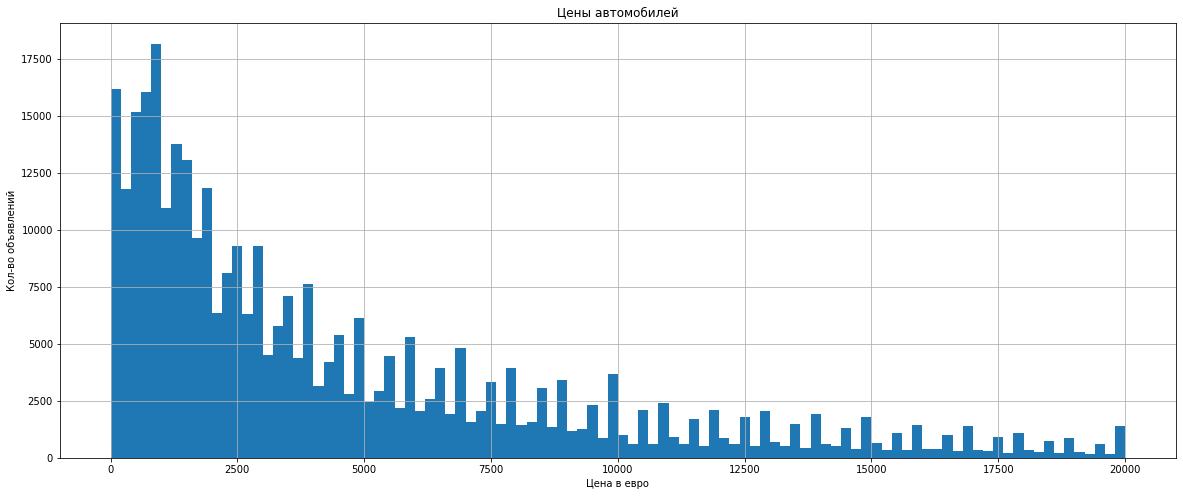

In [17]:
new_data.Price.hist(bins=100, figsize=(20,8))
plt.xlabel('Цена в евро')
plt.ylabel('Кол-во объявлений')
plt.title('Цены автомобилей')
plt.show()

В целом, все логично с увеличением стоимости авто - уменьшается количество предложений. Но по гистограмме мы можем увидеть, что есть немало значений около нуля, предалагаю посмотреть на них более внимательно. 

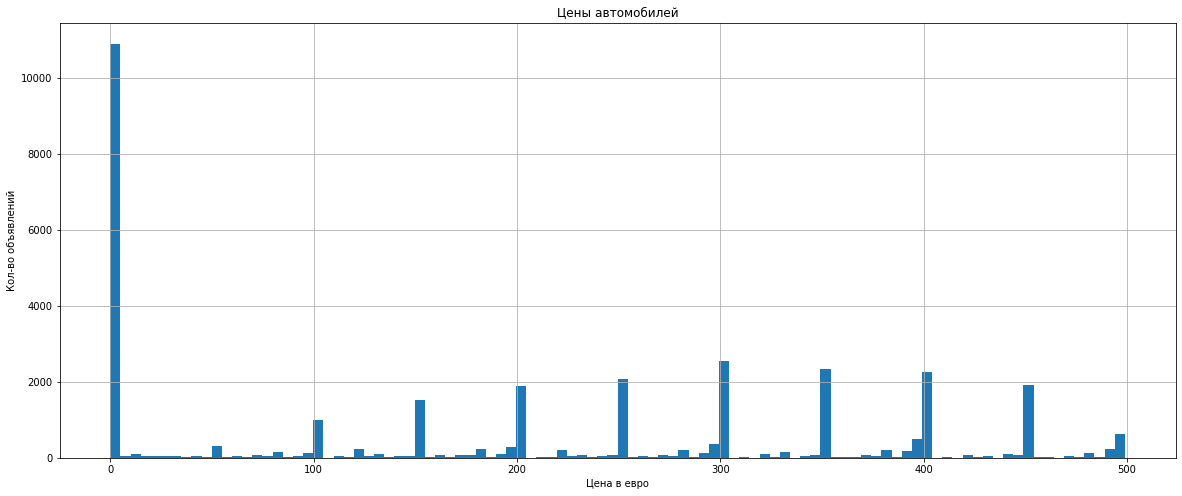

In [18]:
new_data[new_data.Price <500].Price.hist(bins=100, figsize=(20,8))
plt.xlabel('Цена в евро')
plt.ylabel('Кол-во объявлений')
plt.title('Цены автомобилей')
plt.show()

Уберем сомнительные объявления о продаже с ценной менее 40 евро. Нулевые же значения могут быть указаны в случаее если продавец не пожелал указывать цену, а планирует ее определить в случаее непосредственной продажи. 

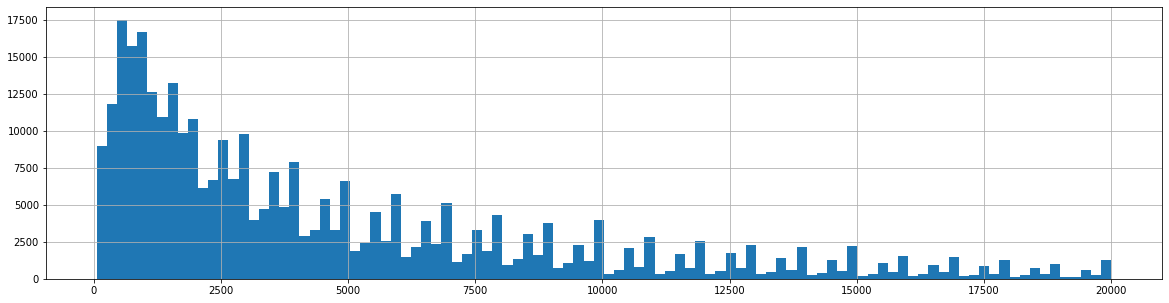

In [19]:
new_data = new_data[new_data['Price']>50]
new_data['Price'].hist(bins=100, figsize=(20,5));

#### <a id='toc1_1_1_2_'></a>[VehicleType - категориальный признак](#toc0_)

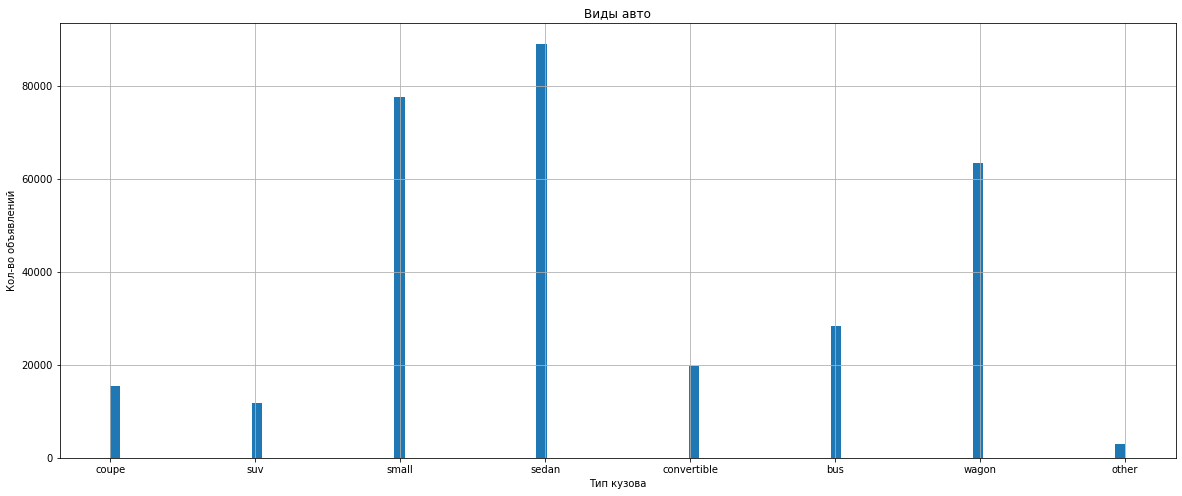

In [20]:
new_data.VehicleType.hist(bins=100, figsize=(20,8))
plt.xlabel('Тип кузова')
plt.ylabel('Кол-во объявлений')
plt.title('Виды авто')
plt.show()

In [21]:
new_data['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [22]:
new_data['VehicleType'].isna().sum()

14752

Пропущенных значений слишком много чтобы их удалять, поставим значение unknown для пропусков.

In [23]:
new_data['VehicleType'].fillna('unknown', inplace=True)

In [24]:
#check
new_data['VehicleType'].isna().sum()

0

#### <a id='toc1_1_1_3_'></a>[RegistrationYear](#toc0_)

In [25]:
new_data['RegistrationYear'].isna().sum()

0

In [26]:
new_data['RegistrationYear'].describe()

count    323497.000000
mean       2002.319505
std          12.205660
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

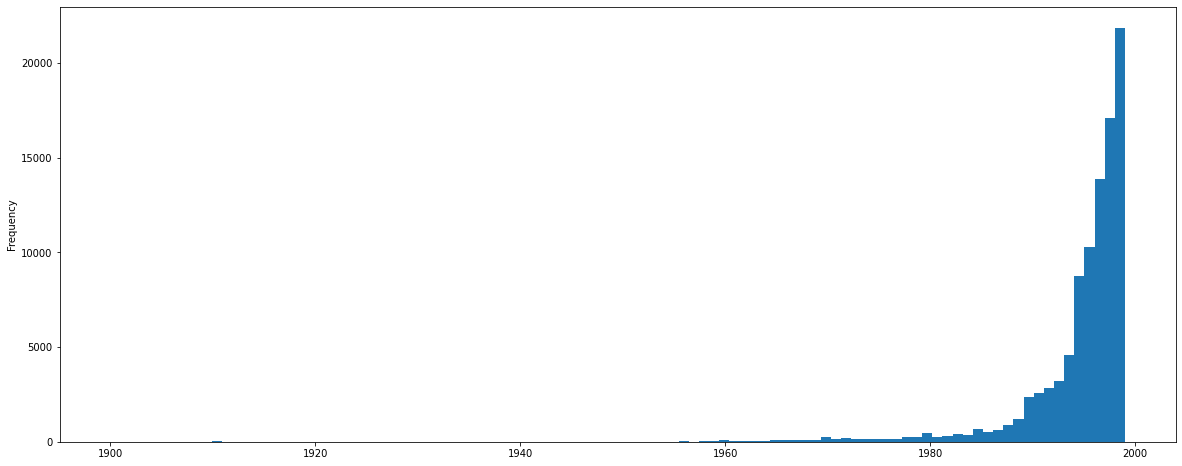

In [27]:
new_data['RegistrationYear'].plot.hist(range=(1900, 1999), bins=100, figsize=(20,8));

In [28]:
new_data = new_data[new_data['RegistrationYear']>1960]

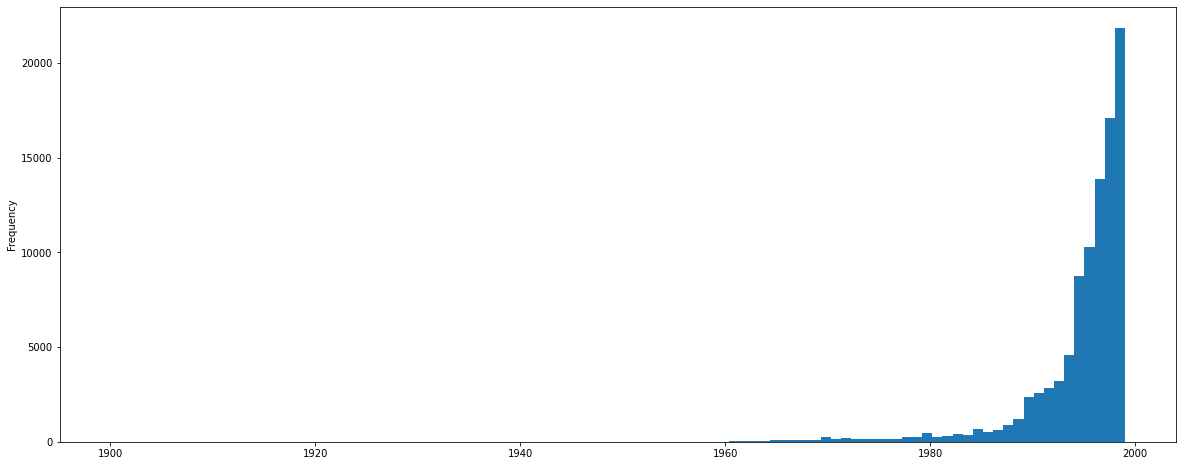

In [29]:
#check
new_data['RegistrationYear'].plot.hist(range=(1900, 1999), bins=100, figsize=(20,8));

Отбросили выброс с годом регистрации 1000 и сделали минимальный стартовый год регистрации 1960год. Также стоит отметить. что на данном этапе у нас уже пропали выбросы с 9999 годом. 

#### <a id='toc1_1_1_4_'></a>[Gearbox  - категориальный признак](#toc0_)

In [30]:
new_data['Gearbox'].isna().sum()

14292

In [31]:
new_data['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [32]:
new_data['Gearbox'].fillna('unknown', inplace=True)

In [33]:
#check
new_data['Gearbox'].isna().sum()

0

Также как и с VehicleType - пропусков слишком много для удаления, заклеили их заглушкой. 

#### <a id='toc1_1_1_5_'></a>[Power](#toc0_)

In [34]:
new_data['Power'].isna().sum()

0

In [35]:
new_data['Power'].describe()

count    323068.000000
mean        112.644412
std         183.570449
min           0.000000
25%          72.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

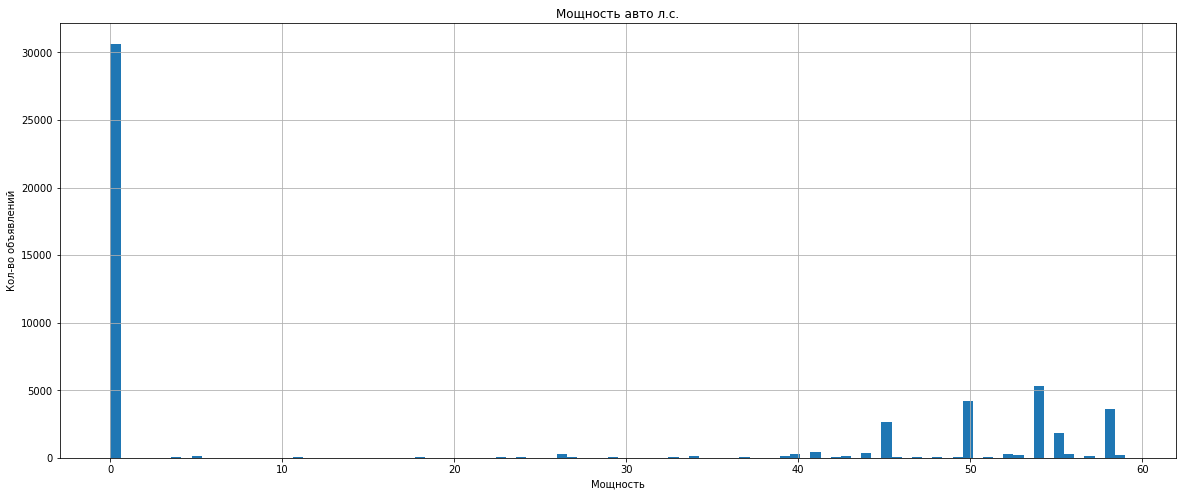

In [36]:
new_data[new_data.Power <60].Power.hist(bins=100, figsize=(20,8))
plt.xlabel('Мощность')
plt.ylabel('Кол-во объявлений')
plt.title('Мощность авто л.с.')
plt.show()

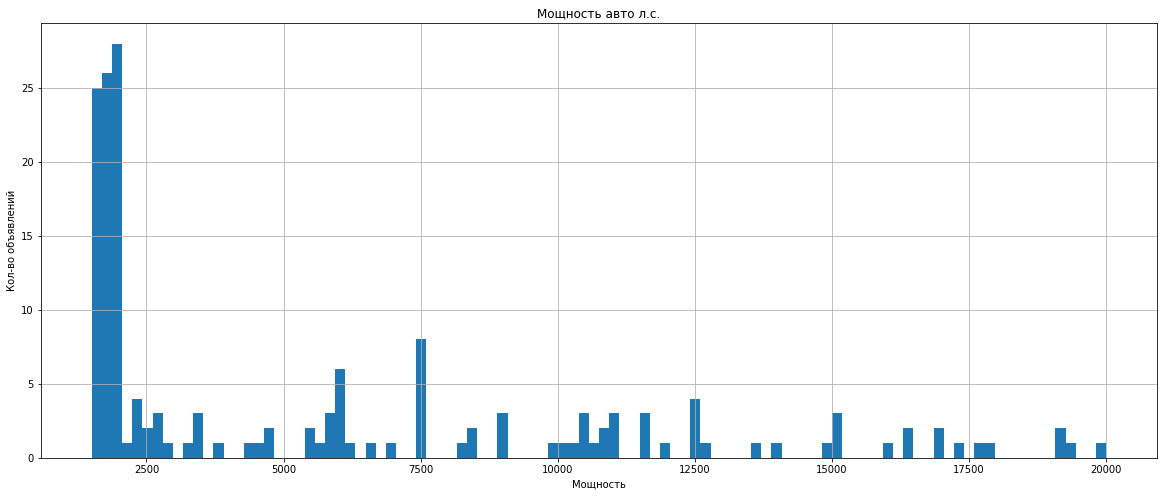

In [37]:
new_data[new_data.Power > 1500].Power.hist(bins=100, figsize=(20,8))
plt.xlabel('Мощность')
plt.ylabel('Кол-во объявлений')
plt.title('Мощность авто л.с.')
plt.show()

In [38]:
count=len(new_data[new_data['Power']>1500])
print(count)

167


Как много гиперкаров однако, но все же, чтобы не было искревлений в показателях, ограничи максимальную мощность в 1500, потеряем всего 167 строк, это не критично. 

In [39]:
new_data = new_data[(new_data['Power']> 40) & (new_data['Power'] <= 1500)] 

In [40]:
#check
new_data['Power'].describe()

count    290772.000000
mean        121.768743
std          57.673215
min          41.000000
25%          79.000000
50%         113.000000
75%         150.000000
max        1500.000000
Name: Power, dtype: float64

#### <a id='toc1_1_1_6_'></a>[Model - категориальный признак](#toc0_)

In [41]:
new_data['Model'].isna().sum()

10369

In [42]:
new_data['Model'].nunique()

249

In [43]:
new_data['Model'].fillna('unknown', inplace=True)
#check
display(new_data['Model'].isna().sum())

0

В столбце с моделями 249 уникальный значений и 10.3к пропусков, удалять их не будем, поставили значение неизвестно.

#### <a id='toc1_1_1_7_'></a>[Kilometer](#toc0_)

In [44]:
new_data['Kilometer'].isna().sum()

0

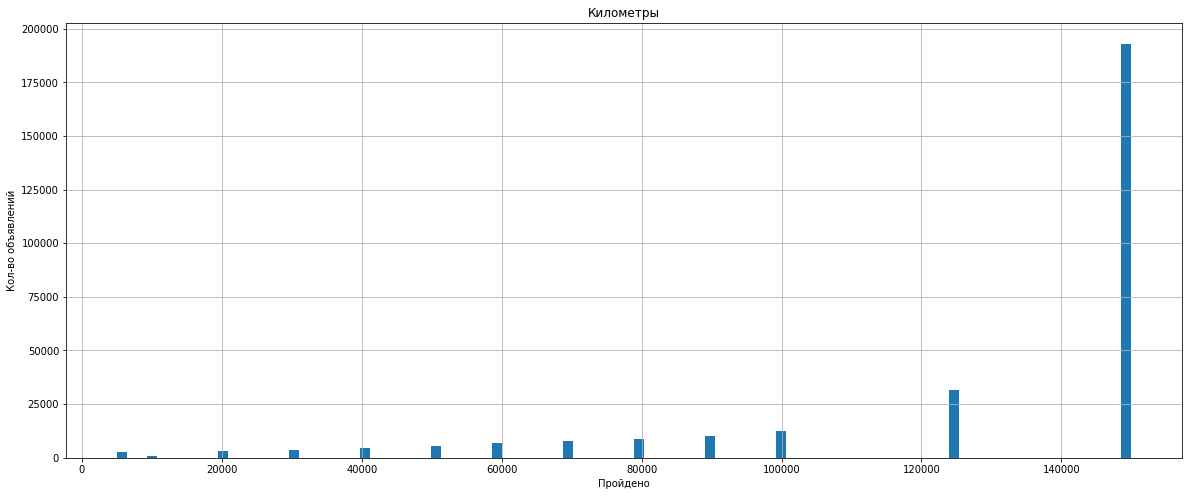

In [45]:
new_data.Kilometer.hist(bins=100, figsize=(20,8))
plt.xlabel('Пройдено')
plt.ylabel('Кол-во объявлений')
plt.title('Километры')
plt.show()

In [46]:
new_data['Kilometer'].unique()

array([125000, 150000,  90000,  30000,  70000, 100000,  60000,   5000,
        20000,  80000,  50000,  40000,  10000])

Мы имеем 13 показателей километража. Пропусков в данном столбце нет, в целом, его можно отнести к категориальному признаку, потому что все значения фиксированные, их не много (на такой большой датасет). Нет разбивок, например: 5432 или 125421. 

#### <a id='toc1_1_1_8_'></a>[RegistrationMonth](#toc0_)

In [47]:
new_data = new_data.drop('RegistrationMonth', axis=1)
#check
display(new_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290772 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             290772 non-null  int64 
 1   VehicleType       290772 non-null  object
 2   RegistrationYear  290772 non-null  int64 
 3   Gearbox           290772 non-null  object
 4   Power             290772 non-null  int64 
 5   Model             290772 non-null  object
 6   Kilometer         290772 non-null  int64 
 7   FuelType          277009 non-null  object
 8   Brand             290772 non-null  object
 9   Repaired          249848 non-null  object
 10  PostalCode        290772 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 26.6+ MB


None

Столбец с месяцем регистрации нам больше не пригодиться, самое важное мы сделали еще в самом начали когда создали отфильтрованный датасет с датой публикации объявлений не позднее апреля месяца 16го года. 

Месяц регистрации врядли оказывает какое либо воздействие на ценовую политику авто. 

#### <a id='toc1_1_1_9_'></a>[FuelType - Категориальный признак](#toc0_)

In [48]:
new_data['FuelType'].isna().sum() 

13763

In [49]:
new_data['FuelType'].nunique()

7

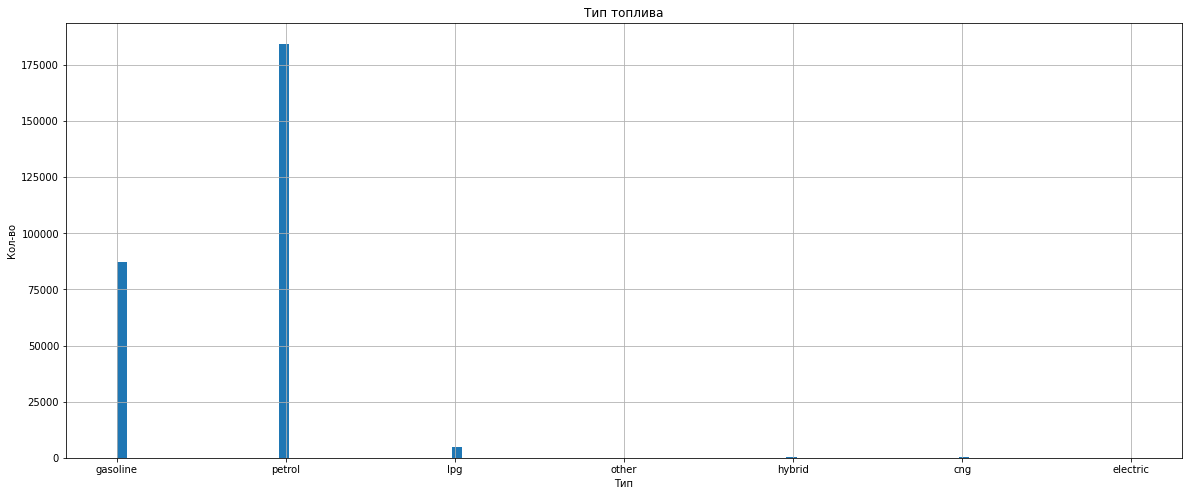

In [50]:
new_data.FuelType.hist(bins=100, figsize=(20,8))
plt.xlabel('Тип')
plt.ylabel('Кол-во')
plt.title('Тип топлива')
plt.show()

In [51]:
new_data['FuelType'].fillna('unknown', inplace=True)
#check
display(new_data['FuelType'].isna().sum())

0

В столбце 7 уникальных значений, есть существенное количество пропусков, их также заполнили параметром "неизвестно"

#### <a id='toc1_1_1_10_'></a>[Brand - Категориальный признак](#toc0_)

In [52]:
display(new_data['Brand'].isna().sum())
display(new_data['Brand'].unique())
display(new_data['Brand'].nunique())

0

array(['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia', 'citroen',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler',
       'sonstige_autos', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'land_rover', 'trabant', 'lada'], dtype=object)

40

Пропусков нет, имеем 40 уникальных категорий. 

#### <a id='toc1_1_1_11_'></a>[Repaired - Категориальный признак.](#toc0_)

In [53]:
display(new_data['Repaired'].isna().sum())
display(new_data['Repaired'].unique())
display(new_data['Repaired'].nunique())

40924

array(['yes', nan, 'no'], dtype=object)

2

In [54]:
new_data['Repaired'].fillna('unknown', inplace=True)
#check
display(new_data['Repaired'].isna().sum())

0

Почти 41 тысяча пропусков была заполнена параметром "неизвестно". Категории всего 2, да и нет. 

#### <a id='toc1_1_1_12_'></a>[PostalCode](#toc0_)

In [55]:
display(new_data['PostalCode'].isna().sum())
display(new_data['PostalCode'].unique())
display(new_data['PostalCode'].nunique())

0

array([66954, 90480, 91074, ..., 86751, 89344, 95691])

8112

Данный столбец не имеет пропусков, в нем 8112 индексов. Данный столбец удалять не будем, так как он отображает местонахождение продавца. 

Кратко по блоку:

    - Приобразовали столбцы с датой в читабельный вид. Исследовали их, затем убрали. 
    - Слепили новый датасет с датой публикации объявлений не старше апреля 2016г. К такой дате мы пришли изучив преобразованные столбцы с датами. 
    - Разобрали каждый признак по отдельности:
        
        - Price - убрали нулевые значения и отсекли все объявления с аномально низкими ценами. 
        - VehicleType - заменили пропущенные значение параметром неизвестно.
        - RegistrationYear - убрали выбросы, публикации теперь от 1960года.
        - Gearbox - заменили пропущенные значение параметром неизвестно.
        - Power - убрали объявления с аномально низкими и сверхвысокими параметрами мощности. 
        - Model - VehicleType - заменили пропущенные значение параметром неизвестно.
        - Kilometer - Пропусков нет, всего 13 значений, можно даже отнести к категориальному признаку. 
        - RegistrationMonth - дропнули в виду ненадобности в дальнейшем исследовании. Месяц на ценовую политику авто вряд-ли существенно повлияет. 
        - FuelType - заменили пропущенные значение параметром неизвестно.
        - Brand - пропусков не имеет, 40 уникальный значений. 
        - Repaired - заменили пропущенные значение параметром неизвестно.
        - PostalCode - пропусков не имеет, данные с индексами удалять не стали, т.к. это по сути местонахождение объявления. 

### <a id='toc1_1_2_'></a>[Разбивка на выборки](#toc0_)

In [56]:
features = new_data.drop('Price', axis = 1)
target = new_data['Price']
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.20, random_state=12345)

features_train, features_test, target_train, target_test = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)
display(features_train.shape)
display(features_valid.shape)
display(features_test.shape)
display(target_train.shape)
display(target_valid.shape)
display(target_test.shape)

(174462, 10)

(58155, 10)

(58155, 10)

(174462,)

(58155,)

(58155,)

### <a id='toc1_1_3_'></a>[Кодировка](#toc0_)

In [58]:
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
features_train_one= (
    pd.DataFrame(encoder.fit_transform(features_train[['VehicleType','Gearbox', 'Model', 'FuelType','Brand', 'Repaired']]).toarray(), 
                 columns=encoder.get_feature_names_out(), index=features_train.index)
)
features_valid_one= (
    pd.DataFrame(encoder.transform(features_valid[['VehicleType','Gearbox', 'Model', 'FuelType','Brand', 'Repaired']]).toarray(),
                 columns=encoder.get_feature_names_out(), index=features_valid.index) 
)
features_test_one= (
    pd.DataFrame(encoder.transform(features_test[['VehicleType','Gearbox', 'Model', 'FuelType','Brand', 'Repaired']]).toarray(),
                 columns=encoder.get_feature_names_out(), index=features_test.index)
)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [59]:
category = ['VehicleType','Gearbox', 'Model', 'FuelType','Brand', 'Repaired']
encoder_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)

features_train_oe = features_train.copy()
features_train_oe[category] = encoder_oe.fit_transform(features_train[category])
target_train_oe = target_train.copy()

features_valid_oe = features_valid.copy()
features_valid_oe[category] = encoder_oe.transform(features_valid[category])
features_valid_oe = features_valid_oe.dropna()
target_valid_oe = target_valid[features_valid_oe.index]

features_test_oe = features_test.copy()
features_test_oe[category] = encoder_oe.transform(features_test[category])
features_test_oe = features_test_oe.dropna()
target_test_oe = target_test[features_test_oe.index]



In [60]:
features_train_oe.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,PostalCode
188662,1.0,2002,0.0,231,11.0,150000,6.0,2.0,0.0,90431
63179,4.0,2006,1.0,200,115.0,90000,6.0,38.0,0.0,52152
302528,1.0,2002,1.0,41,105.0,150000,2.0,32.0,0.0,26441
2946,4.0,2013,1.0,110,179.0,50000,2.0,23.0,0.0,94336
72835,8.0,1999,1.0,150,50.0,30000,6.0,38.0,2.0,94556


### <a id='toc1_1_4_'></a>[Масштабирование](#toc0_)

In [61]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174462 entries, 188662 to 260662
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       174462 non-null  object
 1   RegistrationYear  174462 non-null  int64 
 2   Gearbox           174462 non-null  object
 3   Power             174462 non-null  int64 
 4   Model             174462 non-null  object
 5   Kilometer         174462 non-null  int64 
 6   FuelType          174462 non-null  object
 7   Brand             174462 non-null  object
 8   Repaired          174462 non-null  object
 9   PostalCode        174462 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 14.6+ MB


In [62]:
numeric=['RegistrationYear', 'Power', 'Kilometer', 'PostalCode']
scaler = StandardScaler()
f_train_num=pd.DataFrame(scaler.fit_transform(features_train[numeric]), columns= numeric, index=features_train.index )
f_valid_num=pd.DataFrame(scaler.transform(features_valid[numeric]),columns= numeric, index=features_valid.index)
f_test_num= pd.DataFrame(scaler.transform(features_test[numeric]),columns= numeric, index=features_test.index)

### <a id='toc1_1_5_'></a>[Объеденяем выборки](#toc0_)

In [63]:
features_train_full = features_train_one.join(f_train_num)
features_valid_full = features_valid_one.join(f_valid_num)
features_test_full = features_test_one.join(f_test_num)

## <a id='toc1_2_'></a>[Обучение моделей](#toc0_)

### <a id='toc1_2_1_'></a>[Случайный лес](#toc0_)

In [64]:
best_model = None
best_result = float('inf')
best_param = None
best_depth = None

for est in range(1, 11):
    for depth in range(1,10):
        
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        start_time = time.time()
        model.fit(features_train_oe, target_train_oe)
        end_time = time.time()
        train_time = end_time - start_time
        start_time = time.time()
        pred_val = model.predict(features_valid_oe)
        end_time = time.time()
        pred_time = end_time - start_time
        rmse = np.sqrt(mean_squared_error(target_valid_oe, pred_val))
    
        if rmse < best_result:
            best_model = model
            best_param = est
            best_depth = depth
            best_result = rmse

print('Лучшая модель:', best_model)
print('Лучший параметр est', best_param)
print('Лучший параметр depth', best_depth)
print('RMSE', best_result)
print('Время обучения:', train_time, 'сек.')
print('Время предсказания:', pred_time, 'сек.')

Лучшая модель: RandomForestRegressor(max_depth=9, n_estimators=10, random_state=12345)
Лучший параметр est 10
Лучший параметр depth 9
RMSE 1937.1592539615208
Время обучения: 3.442481517791748 сек.
Время предсказания: 0.048775672912597656 сек.


In [65]:
# Пока не требуется
# model = RandomForestRegressor(random_state=12345, n_estimators=10, max_depth=9)

# start_time = time.time()
# model.fit(features_train_or, target_train)
# end_time = time.time()
# train_time = end_time - start_time

# start_time = time.time()
# pred_test = model.predict(features_test_or)
# end_time = time.time()
# pred_time = end_time - start_time

# rmse = np.sqrt(mean_squared_error(target_test, pred_test))
# print('Время обучения:', train_time, 'сек.')
# print('Время предсказания на тестовой:', pred_time, 'сек.')
# print('RMSE модели на тестовой выборке:', rmse)

### <a id='toc1_2_2_'></a>[Линейная регрессия](#toc0_)

In [66]:
model=LinearRegression()

start_time = time.time()
model.fit(features_train_full,target_train)
end_time = time.time()
train_time = end_time - start_time

start_time = time.time()
pred_val = model.predict(features_valid_full)
end_time = time.time()
pred_time = end_time - start_time
mse = mean_squared_error(target_valid, pred_val)
rmse = np.sqrt(mse)
print('Время обучения:', train_time, 'сек.')
print('Время предсказания на валидации:', pred_time, 'сек.')
print('RMSE модели на валидационной выборке:', rmse)


Время обучения: 18.143405437469482 сек.
Время предсказания на валидации: 0.2956826686859131 сек.
RMSE модели на валидационной выборке: 2592.1040460758772


### <a id='toc1_2_3_'></a>[LightGBM](#toc0_)

In [67]:

model = LGBMRegressor(random_state=12345)

start_time = time.time()
model.fit(features_train_oe,target_train)
end_time = time.time()

train_time = end_time - start_time
start_time = time.time()
pred_val = model.predict(features_valid_oe)
end_time = time.time()
pred_time = end_time - start_time
mse = mean_squared_error(target_valid_oe, pred_val)
rmse = np.sqrt(mse)

print('Время обучения:', train_time, 'сек.')
print('Время предсказания на валидации:', pred_time, 'сек.')
print('RMSE модели на валидационной выборке:', rmse)

Время обучения: 4.204513788223267 сек.
Время предсказания на валидации: 0.5057084560394287 сек.
RMSE модели на валидационной выборке: 1652.5702926615377


### <a id='toc1_2_4_'></a>[CatBoost](#toc0_)

In [69]:
model =CatBoostRegressor(iterations=500)
start_time = time.time()
model.fit(features_train_oe,target_train_oe, verbose=100)
end_time = time.time()
train_time = end_time - start_time

start_time = time.time()
pred_val = model.predict(features_valid_oe)
end_time = time.time()
pred_time = end_time - start_time
mse = mean_squared_error(target_valid_oe, pred_val)
rmse = np.sqrt(mse)


print('Время обучения:', train_time, 'сек.')
print('Время предсказания на валидации:', pred_time, 'сек.')
print('RMSE модели на валидационной выборке:', rmse)

Learning rate set to 0.162594
0:	learn: 4120.5175858	total: 29.5ms	remaining: 14.7s
100:	learn: 1694.8912132	total: 2.52s	remaining: 9.97s
200:	learn: 1607.4788885	total: 5.02s	remaining: 7.46s
300:	learn: 1559.3116962	total: 7.58s	remaining: 5.01s
400:	learn: 1525.9841388	total: 10.1s	remaining: 2.49s
499:	learn: 1498.9778114	total: 12.6s	remaining: 0us
Время обучения: 13.656612634658813 сек.
Время предсказания на валидации: 0.03335118293762207 сек.
RMSE модели на валидационной выборке: 1577.0676998124752


## <a id='toc1_3_'></a>[Анализ моделей](#toc0_)

In [71]:
table = {'Модели':
    ['Случайный лес', 'Линейная регрессия', 'LGBM', 'CatBoost'],
         'Время обучения': [3.442481517791748, 18.143405437469482, 4.204513788223267, 13.656612634658813],
         'Время предсказания на валидации':[0.048775672912597656, 0.2956826686859131, 0.5057084560394287, 0.03335118293762207],
         'RMSE valid':[1937.1592539615208, 2592.1040460758772, 1652.5702926615377, 1577.0676998124752]
         
}

table = pd.DataFrame(table)
table.head()
# Больше никогда не буду так лениться и записывать однотипные переменны. Такую табличку пишу в последний раз. 

,Модели,Время обучения,Время предсказания на валидации,RMSE valid
0,Случайный лес,3.442482,0.048776,1937.159254
1,Линейная регрессия,18.143405,0.295683,2592.104046
2,LGBM,4.204514,0.505708,1652.570293
3,CatBoost,13.656613,0.033351,1577.067700


Итог:

- Лудшее время обучения показала модель случайного леса, не сильно отстает от нее LGBM.  Худшее у линейной регрессии, она значительно уступает по времени обучения. 
- Лучшие результаты по времени предсказания у CatBoost, за ним случайный лес. А тут дольше всего думает моделька LGBM. 
- Финалист по метрике RMSE - CatBoost. Эта модель  существенно оторвалась от всех остальных. Худший показетель у линейной регресии. 

Не смотря на более длительное обученеи, модель CatBoost  выигрывает всех в скорости предсказания, а главное в качестве. Поэтому ее будет брать в качесте лучшей модели. 

Можно конечно пожертовать немного скоростью предсказания и качеством модели и выбрать модельку LGBM, но момент предсказывания на текущем исследовании составляет разницу во времени 0.47 секундны, не в пользу LGBM. 

### <a id='toc1_3_1_'></a>[Проверка лучшей на тестовых данных](#toc0_)

In [73]:
model =CatBoostRegressor(iterations=500)
start_time = time.time()
model.fit(features_train_oe,target_train_oe, verbose=100)
end_time = time.time()
train_time = end_time - start_time

start_time = time.time()
pred_test = model.predict(features_test_oe)
end_time = time.time()
pred_time = end_time - start_time
mse = mean_squared_error(target_test_oe, pred_test)
rmse = np.sqrt(mse)


print('Время обучения:', train_time, 'сек.')
print('Время предсказания на валидации:', pred_time, 'сек.')
print('RMSE модели на тестовой выборке:', rmse)

Learning rate set to 0.162594
0:	learn: 4120.5175858	total: 25.9ms	remaining: 12.9s
100:	learn: 1694.8912132	total: 2.46s	remaining: 9.7s
200:	learn: 1607.4788885	total: 4.87s	remaining: 7.24s
300:	learn: 1559.3116962	total: 7.28s	remaining: 4.82s
400:	learn: 1525.9841388	total: 9.64s	remaining: 2.38s
499:	learn: 1498.9778114	total: 12s	remaining: 0us
Время обучения: 13.158280611038208 сек.
Время предсказания на валидации: 0.03490400314331055 сек.
RMSE модели на тестовой выборке: 1563.7987566129425


На тестовой выборке моделька показала качество еще лучше чем на валидации, хоть и не намного (1577 - valid, против 1563 - test). 

## <a id='toc1_4_'></a>[Вывод:](#toc0_)

При проверки моделей на валидационной выборке было принято решение взять модель CatBoos, так как она показала лучшие результаты и оптимальное время работоспособности. 

Проверка на тестовых данных показало положительные результаты метрики RMSE 1563.79